In [1]:
import torch
from typing import Tuple
import numpy as np

In [2]:
def gd_factorise_ad(A: torch.Tensor, rank: int, num_epochs = 1000, lr = 0.01):
    
    U = torch.rand(A.shape[0], rank, requires_grad = True)
    V = torch.rand(A.shape[1], rank, requires_grad = True)
    
    error = 0
    for i in range(num_epochs):
        
        mse_loss = torch.nn.functional.mse_loss(torch.mm(U, V.t()), A, reduction = 'sum')    
        mse_loss.backward()
        U.data = U.data - (lr*U.grad)
        V.data = V.data - (lr*V.grad)
        error = mse_loss
        
        U.grad.data.zero_()
        V.grad.data.zero_()
    return U, V, error

In [3]:
matrix = torch.tensor([[0.3374, 0.6005, 0.1735], [3.3359, 0.0492, 1.8374], [2.9407, 0.5301, 2.2620]])
U, V , error = gd_factorise_ad(matrix, 2)

In [4]:
error

tensor(0.1219, grad_fn=<MseLossBackward>)

In [5]:
print(U)

tensor([[ 0.5602, -0.2053],
        [ 0.7381,  1.6186],
        [ 1.2826,  1.1418]], requires_grad=True)


In [6]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None, encoding="utf-8")
data = torch.tensor(df.iloc[:, [0,1,2,3]].values)
data = data - data.mean(dim=0)

In [7]:
U_svd, S, V = torch.svd(data)
S[-1] = 0
S[-2] = 0
temp = torch.mm(U_svd, torch.diag(S))
matrix_const = torch.mm(temp, V.t())
torch.nn.functional.mse_loss(data, matrix_const, reduction = 'sum')

tensor(15.2288, dtype=torch.float64)

In [8]:
U_data, V_data, error_data = gd_factorise_ad(data.float(), 2)
torch.nn.functional.mse_loss(data, torch.mm(U_data, V_data.t()), reduction = 'sum')

tensor(15.2289, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [9]:
import matplotlib.pyplot as plt

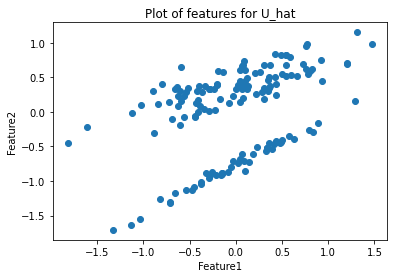

In [55]:
plt.scatter(U_data[:, 0].detach().numpy(), U_data[:, 1].detach().numpy())
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Plot of features for U_hat')
plt.show()

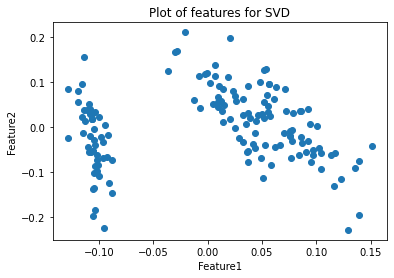

In [57]:
plt.scatter(U_svd[:, 0], U_svd[:, 1])
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Plot of features for SVD')
plt.show()

In [12]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df = df.sample(frac=1) #shuffle

# add label indices column
mapping = {k: v for v, k in enumerate(df [4]. unique())}
df[5] = df[4].map(mapping)

# normalise data
alldata = torch.tensor(df.iloc[:, [0,1,2,3]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)
# create datasets
targets_tr = torch.tensor(df.iloc[:100, 5].values, dtype=torch.long)
targets_va = torch.tensor(df.iloc[100:, 5].values, dtype=torch.long)
data_tr = alldata [:100]
data_va = alldata [100:]

In [46]:
def gd_factorise_ad(A: torch.Tensor, y: torch.Tensor, data_va: torch.Tensor, targets_va: torch.Tensor,rank: int, 
                    num_epochs = 100, lr = 0.01):
    
    W1 = torch.rand(4, 12, requires_grad = True)
    W2 = torch.rand(12, 3, requires_grad = True)
    b1= torch.zeros(1, requires_grad = True)
    b2= torch.zeros(1, requires_grad = True)
    
    train_acc = 0
    val_acc = 0
    for i in range(num_epochs):
        
        logits = torch.relu(A @ W1 + b1) @ W2 + b2
        loss = torch.nn.functional.cross_entropy(logits, y, reduction="sum")
        loss.backward()
        W1.data = W1.data - (lr*W1.grad)
        W2.data = W2.data - (lr*W2.grad)
        b1.data = b1.data - (lr*b1.grad)
        b2.data = b2.data - (lr*b2.grad)
        
        W1.grad.data.zero_()
        W2.grad.data.zero_()
        b1.grad.data.zero_()
        b2.grad.data.zero_()

        if i == (num_epochs - 1):
            preds = torch.argmax(torch.relu(A @ W1 + b1) @ W2 + b2, axis=1)
            train_acc = (y == preds).sum() / preds.shape[0]
            
            preds_va = torch.argmax(torch.relu(data_va @ W1 + b1) @ W2 + b2, axis=1)
            val_acc = (targets_va == preds_va).sum() / preds_va.shape[0]

    return train_acc, val_acc

In [50]:
train_acc_list = []
val_acc_list = []

for i in range(10):
    train_acc, val_acc = gd_factorise_ad(data_tr,targets_tr, data_va, targets_va, 2)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

In [54]:
import pandas as pd

d = {'Training Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list}
print(pd.DataFrame(d))

  Training Accuracy Validation Accuracy
0    tensor(0.9400)      tensor(0.9200)
1    tensor(0.9300)      tensor(0.9000)
2    tensor(0.9500)      tensor(0.9200)
3    tensor(0.9500)      tensor(0.9000)
4    tensor(0.6700)      tensor(0.6200)
5    tensor(0.9500)      tensor(0.9000)
6    tensor(0.9500)      tensor(0.9200)
7    tensor(0.9500)      tensor(0.9000)
8    tensor(0.9500)      tensor(0.9200)
9    tensor(0.9400)      tensor(0.8800)
